In [39]:
#沿用上一次的作业生成数据集
import numpy as np
def get_data(num,expect,variation):
    m=np.array(expect)
    s=np.array(variation)
    raw=np.random.multivariate_normal(m,s,num)
    return raw
def get_dataset(num,expect1,variation1,expect2,variation2):
    raw=get_data(num,expect1,variation1)
    ones=np.ones((num,1))
    aug_data=np.concatenate([ones,raw],axis=1)
    labels=np.ones((num,1))
    final_data=np.concatenate([aug_data,labels],axis=1)
    raw_1=get_data(num,expect2,variation2)
    neg_labels=-np.ones((num,1))
    aug_data_1=np.concatenate([ones,raw_1],axis=1)
    final_data_1=np.concatenate([aug_data_1,neg_labels],axis=1)
    dataset=np.concatenate([final_data,final_data_1],axis=0)
    #打乱
    np.random.shuffle(dataset)
    return dataset
source_data=get_dataset(200,[3,0],[[1,0],[0,1]],[0,3],[[1,0],[0,1]])
print('shape of dataset:',source_data.shape)
#数据集划分
train_set=source_data[0:320]
test_set=source_data[320:]

shape of dataset: (400, 4)


In [40]:
#以下是Primal-SVM求解
from cvxopt import solvers,matrix
def primal_svm(train_set):
    d=train_set.shape[-1]-2
    #二次规划函数的参数的定义似乎与ppt里面不太一样
    Q=np.eye(d+1,dtype=float)
    Q[0,0]=0.0
    P=np.zeros((d+1,1))
    A=-train_set[:,-1].reshape(-1,1)*train_set[:,:-1]
    C=-np.ones((train_set.shape[0],1),dtype=float)
    #转换成cvxopt需要的格式
    Q=matrix(Q)
    P=matrix(P)
    A=matrix(A)
    C=matrix(C)
    #求解
    solvers.options['show_progress'] = True
    sol = solvers.qp(Q,P,A,C)
    return sol   


In [41]:
#求解
sol=primal_svm(train_set)
w=np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  7.5949e-02  1.8045e+02  1e+03  2e+00  1e+03
 1:  3.9516e-01 -2.4197e+02  9e+02  1e+00  8e+02
 2:  5.9283e-01 -1.2075e+02  9e+02  1e+00  8e+02
 3:  8.0238e-01  1.8919e+02  9e+02  1e+00  7e+02
 4:  1.5598e+00  2.6640e+03  1e+03  1e+00  6e+02
 5:  5.5020e+00  8.6008e+03  2e+03  1e+00  6e+02
 6:  2.9211e+01 -8.6572e+02  4e+03  9e-01  6e+02
 7:  1.3523e+02  2.8748e+03  3e+03  6e-01  4e+02
 8:  4.9888e+02 -1.3661e+03  2e+03  5e-02  3e+01
 9:  3.6639e+02 -4.0931e+02  8e+02  2e-02  1e+01
10:  4.1597e+02  2.1556e+02  2e+02  1e-14  2e-11
11:  3.7083e+02  3.6760e+02  3e+00  1e-14  1e-11
12:  3.7025e+02  3.7022e+02  3e-02  1e-14  4e-12
13:  3.7024e+02  3.7024e+02  3e-04  1e-14  1e-11
Optimal solution found.


In [42]:
#测试函数
def eval(test_set,weight):
    error_rate=0
    weight=np.squeeze(weight) 
    for j in range(test_set.shape[0]):
        if np.dot(weight,test_set[j,0:-1])*test_set[j][-1]<0:
            error_rate+=1
    print('正确率为:{}%'.format((1-error_rate/test_set.shape[0])*100))
print('训练集：')
eval(train_set,w)
print('测试集')
eval(test_set,w)

训练集：
正确率为:100.0%
测试集
正确率为:98.75%


训练集可视化


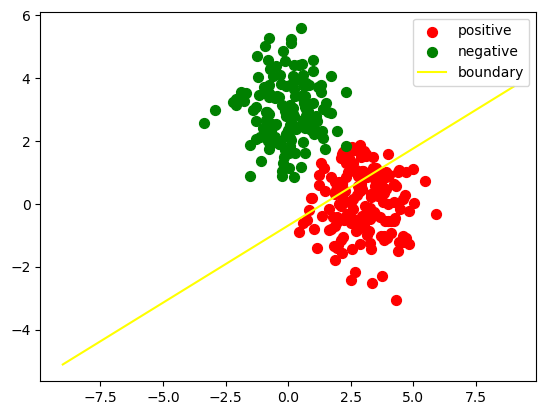

测试集可视化


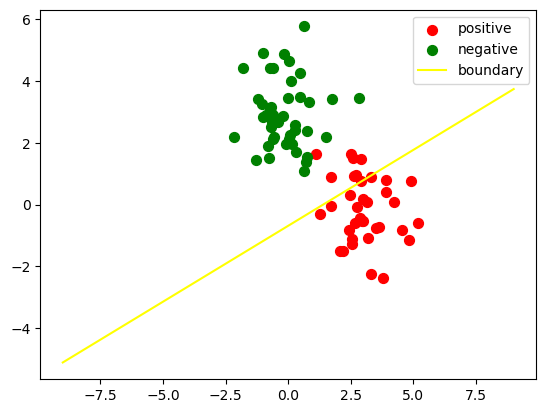

In [43]:
#画图函数
#从上一次作业照搬过来
import matplotlib.pyplot as plt
def draw(dataset, weight):
    x_po= []
    y_po= []
    x_ne= []
    y_ne= []
    for i in range(dataset.shape[0]):
        if dataset[i][-1] == 1:
            x_po.append(dataset[i][1])
            y_po.append(dataset[i][2])
        elif dataset[i][-1] == -1:
            x_ne.append(dataset[i][1])
            y_ne.append(dataset[i][2])

    x_line=np.linspace(-9, 9, 100)
    y_line = -(weight[1] / weight[2]) * x_line + weight[0] / weight[2]
    plt.scatter(x_po, y_po, color='red', s=50, label='positive')
    plt.scatter(x_ne, y_ne, color='green', s=50, label='negative')
    plt.plot(x_line, y_line, color='yellow', label='boundary')
    plt.legend(loc='best')
    plt.show()
print('训练集可视化')
draw(train_set,w)
print('测试集可视化')
draw(test_set,w)

In [44]:
#以下是dual_SVM的实现
def dual_svm(train_set):
    Z=train_set[:,1:-1]
    Y=train_set[:,-1].reshape(-1,1)
    Q1=Z@np.transpose(Z)
    Q2=Y@np.transpose(Y)
    Q=Q1*Q2
    P=-np.ones((train_set.shape[0],1),dtype=float)
    A=-np.eye(train_set.shape[0],dtype=float)
    C=np.zeros((train_set.shape[0],1),dtype=float)
    R=np.transpose(Y)
    V=np.zeros((1,1),dtype=float)
    #格式转换，与cvxopt匹配
    Q=matrix(Q)
    P=matrix(P)
    A=matrix(A)
    C=matrix(C)
    R=matrix(R)
    V=matrix(V)

    sol=solvers.qp(Q, P, A, C, R, V)
    alpha=np.array(sol['x']).reshape(-1,1)
    alpha=np.absolute(alpha)
    alpha=alpha*(alpha>1e-8)
    #求w
    sv_idx=np.where(alpha>1e-8)[0]
    w=np.sum(alpha*Y*Z,axis=0).reshape(1,-1)
    #求b
    idx0=sv_idx[0]
    sv=Z[idx0,:].reshape(-1,1)
    yv=Y[idx0,0].reshape(-1,1)
    b=yv-np.dot(w,sv)
    #将b与w拼接
    w=np.concatenate((b,w),-1)
    w=np.squeeze(w)
    return w,sv_idx

In [45]:
#以下分别求出alpha和支撑向量所对应的下标
w,sv_idx=dual_svm(train_set)
print('支撑向量对应下标为：',sv_idx)

     pcost       dcost       gap    pres   dres
 0: -5.9093e+01 -1.2566e+02  1e+03  4e+01  2e+00
 1: -1.0176e+02 -1.3273e+02  9e+02  2e+01  1e+00
 2: -2.8713e+02 -3.4279e+02  9e+02  2e+01  1e+00
 3: -6.7595e+02 -7.4512e+02  9e+02  2e+01  1e+00
 4: -3.4266e+03 -3.3699e+03  1e+03  2e+01  1e+00
 5: -1.0271e+04 -9.9072e+03  2e+03  2e+01  1e+00
 6: -3.0682e+03 -2.8032e+03  4e+03  2e+01  9e-01
 7: -9.0584e+03 -5.9532e+03  3e+03  1e+01  6e-01
 8:  3.6737e+02 -5.0579e+02  2e+03  9e-01  5e-02
 9:  1.0294e+02 -3.7137e+02  8e+02  3e-01  2e-02
10: -2.1556e+02 -4.1597e+02  2e+02  2e-13  5e-13
11: -3.6760e+02 -3.7083e+02  3e+00  2e-13  6e-13
12: -3.7022e+02 -3.7025e+02  3e-02  2e-13  6e-13
13: -3.7024e+02 -3.7024e+02  3e-04  2e-13  6e-13
Optimal solution found.
支撑向量对应下标为： [  2   3   4   6   7   8   9  11  12  13  14  15  17  18  19  20  21  22
  23  24  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  47  48  49  51  52  53  54  55  57  58  59  60  62  64
  65  66  67

In [46]:
#测试
print('训练集：')
eval(train_set,w)
print('测试集')
eval(test_set,w)

训练集：
正确率为:82.1875%
测试集
正确率为:81.25%


训练集可视化


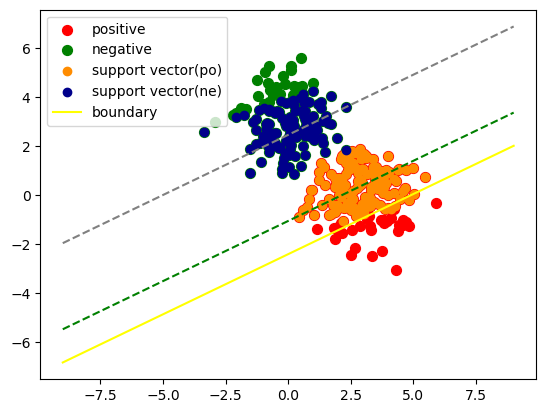

测试集可视化


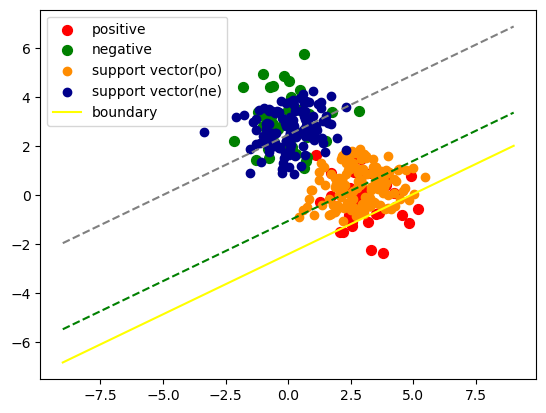

In [47]:
#由于要画出间隔面，故这里用另一个版本的画图函数
#以下的画图函数不算完美，是因为我希望在原来的画图函数上做尽可能少的改动
def draw(dataset,dataset1, weight,idx,train=True):
    x_po= []
    y_po= []
    x_ne= []
    y_ne= []
    svx_po=[]
    svx_ne=[]
    svy_po=[]
    svy_ne=[]
    idx=list(idx)
    for i in range(dataset.shape[0]):
        if dataset[i][-1] == 1:
            x_po.append(dataset[i][1])
            y_po.append(dataset[i][2])
        elif dataset[i][-1] == -1:
            x_ne.append(dataset[i][1])
            y_ne.append(dataset[i][2])
    for j in range(len(idx)):
        if dataset1[idx[j]][-1]==1:
            svx_po.append(dataset1[idx[j]][1])
            svy_po.append(dataset1[idx[j]][2])
        else:
            svx_ne.append(dataset1[idx[j]][1])
            svy_ne.append(dataset1[idx[j]][2])

    x_line=np.linspace(-9, 9, 100)
    y_line = -(weight[1] / weight[2]) * x_line + weight[0] / weight[2]
    plt.scatter(x_po, y_po, color='red', s=50, label='positive')
    plt.scatter(x_ne, y_ne, color='green', s=50, label='negative')
    plt.scatter(svx_po,svy_po,color='darkorange',marker='o',label='support vector(po)')
    plt.scatter(svx_ne,svy_ne,color='darkblue',marker='o',label='support vector(ne)')
    plt.plot(x_line, y_line, color='yellow', label='boundary')

    po_yline=svy_po[0]-(weight[1] / weight[2])*(x_line-svx_po[0])
    ne_yline=svy_ne[0]-(weight[1] / weight[2])*(x_line-svx_ne[0])
    plt.plot(x_line, po_yline, '--', c='green')
    plt.plot(x_line, ne_yline, '--', c='gray')

    plt.legend(loc='best')
    plt.show()
print('训练集可视化')
draw(train_set,train_set,w,sv_idx)
print('测试集可视化')
draw(test_set,train_set,w,sv_idx)

In [48]:
#以下是kernel_svm的实现
def kernel_value(x1,x2,kernel_type):
    n, dimension1 = x1.shape
    m, dimension2 = x2.shape
    if kernel_type=='poly':
        kernel_value = np.power(1+x2@np.transpose(x1),4)
    elif kernel_type=='gauss':
        x1x1=np.power(np.linalg.norm(x1,axis=-1).reshape(1,-1),2)
        x2x2=np.power(np.linalg.norm(x2,axis=-1).reshape(-1,1),2)
        x1x2=x2@np.transpose(x1)
        kernel_value=np.exp(2*x1x2-x1x1-x2x2)
    return kernel_value

In [49]:
#以下是核函数支撑向量机的求解
def kernel_svm(train_set,kernel_type):
    ker=kernel_value(train_set[:,1:-1],train_set[:,1:-1],kernel_type)
    yy=train_set[:,-1].reshape(-1,1)@train_set[:,-1].reshape(1,-1)
    Q=ker*yy
    P=-np.ones((train_set.shape[0],1))
    A=-np.eye(train_set.shape[0])
    R=train_set[:,-1].reshape(1,-1)
    C=np.zeros((train_set.shape[0],1))
    V=np.zeros((1,1))
    #格式转换，与cvxopt匹配
    Q=matrix(Q)
    P=matrix(P)
    A=matrix(A)
    C=matrix(C)
    R=matrix(R)
    V=matrix(V)

    #以下分别求出了支撑向量和对应的值
    sol=solvers.qp(Q, P, A, C, R, V)
    alpha=np.array(sol['x']).reshape(-1,1)
    sv_idx=np.where(alpha>1e-6)[0]
    sv_alpha=alpha[sv_idx,:].reshape(-1,1)
    sv_label=train_set[sv_idx,-1].reshape(-1,1)
    sv_points=train_set[sv_idx,1:-1]

    #求b
    xm=sv_points[0,:].reshape(1,-1)
    ym=sv_label[0,:].reshape(1,-1)
    b=ym-np.sum(sv_alpha*sv_label*kernel_value(xm,sv_points,kernel_type))
    
    return sv_alpha,sv_idx,sv_label,sv_points,b


In [50]:
#求解,核函数为四次多项式
sv_alpha,sv_idx,sv_label,sv_points,b=kernel_svm(train_set,'poly')
print(sv_idx)

     pcost       dcost       gap    pres   dres
 0: -2.5836e+01 -5.9824e+01  1e+03  2e+01  2e+00
 1: -4.5411e+01 -6.5702e+01  7e+02  1e+01  1e+00
 2: -1.1811e+02 -1.1042e+02  5e+02  9e+00  9e-01
 3: -2.1004e+02 -1.9166e+02  5e+02  9e+00  9e-01
 4: -5.6926e+02 -4.7701e+02  6e+02  8e+00  8e-01
 5: -3.9183e+02 -2.5204e+02  6e+02  6e+00  6e-01
 6: -2.2790e+02 -8.1266e+01  4e+02  3e+00  3e-01
 7: -9.2918e+01 -2.2659e+01  3e+02  2e+00  2e-01
 8: -2.4842e+01 -3.5361e+00  1e+02  5e-01  5e-02
 9: -3.7182e+00 -9.6247e-01  2e+01  7e-02  7e-03
10: -9.8778e-01 -5.9732e-01  7e+00  3e-02  3e-03
11: -3.1642e-01 -4.4068e-01  2e+00  5e-03  5e-04
12: -2.8574e-01 -4.1673e-01  1e+00  3e-03  3e-04
13: -3.1663e-01 -3.8939e-01  5e-01  1e-03  1e-04
14: -3.5645e-01 -3.6482e-01  2e-01  5e-04  5e-05
15: -3.5290e-01 -3.4416e-01  4e-02  1e-04  1e-05
16: -3.4105e-01 -3.4094e-01  1e-03  2e-06  2e-07
17: -3.4088e-01 -3.4088e-01  2e-05  3e-08  3e-09
18: -3.4088e-01 -3.4088e-01  6e-07  3e-10  3e-11
19: -3.4088e-01 -3.40

In [51]:
def eval(test_set,sv_alpha,sv_idx,sv_label,sv_points,b,kernel_type):
    error=0
    for i in range(test_set.shape[0]):
        test_point=test_set[i,1:-1].reshape(1,-1)
        test_label=test_set[i,-1].reshape(-1,1)
        prediction=np.sum(sv_alpha*sv_label*kernel_value(test_point,sv_points,kernel_type))+b
        if prediction*test_label<0:
            error+=1
    print('正确率为:{}%'.format((1-error/test_set.shape[0])*100))

In [52]:
print('训练集：')
eval(train_set,sv_alpha,sv_idx,sv_label,sv_points,b,'poly')
print('测试集：')
eval(test_set,sv_alpha,sv_idx,sv_label,sv_points,b,'poly')

训练集：
正确率为:100.0%
测试集：
正确率为:98.75%


训练集可视化


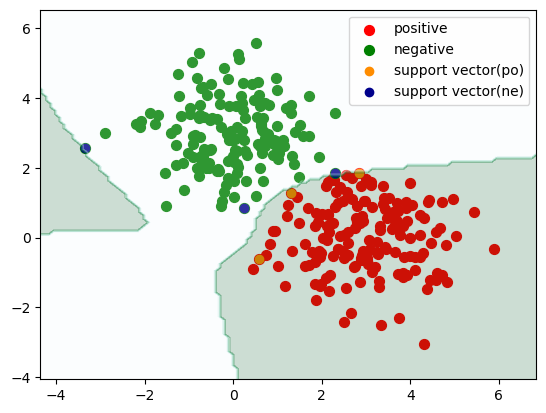

测试集可视化


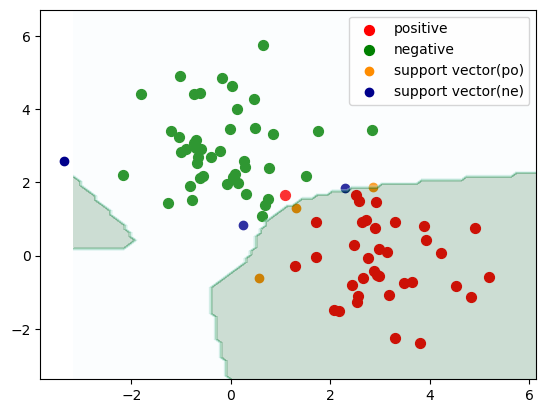

In [53]:
#可视化，由于需要画出弯曲边界，draw函数需要重写（部分照搬）
def draw(dataset,dataset1, weight,sv_alpha,sv_idx,sv_label,sv_points,b,kernel_type,train=True):
    x_po= []
    y_po= []
    x_ne= []
    y_ne= []
    svx_po=[]
    svx_ne=[]
    svy_po=[]
    svy_ne=[]
    idx=list(sv_idx)
    for i in range(dataset.shape[0]):
        if dataset[i][-1] == 1:
            x_po.append(dataset[i][1])
            y_po.append(dataset[i][2])
        elif dataset[i][-1] == -1:
            x_ne.append(dataset[i][1])
            y_ne.append(dataset[i][2])
    for j in range(len(idx)):
        if dataset1[idx[j]][-1]==1:
            svx_po.append(dataset1[idx[j]][1])
            svy_po.append(dataset1[idx[j]][2])
        else:
            svx_ne.append(dataset1[idx[j]][1])
            svy_ne.append(dataset1[idx[j]][2])

    plt.scatter(x_po, y_po, color='red', s=50, label='positive')
    plt.scatter(x_ne, y_ne, color='green', s=50, label='negative')
    plt.scatter(svx_po,svy_po,color='darkorange',marker='o',label='support vector(po)')
    plt.scatter(svx_ne,svy_ne,color='darkblue',marker='o',label='support vector(ne)')

    x_min, x_max =dataset[:,1].min() -1, dataset[:, 1].max() + 1  
    y_min, y_max =dataset[:,2].min() -1, dataset[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    xy=np.c_[xx.ravel(), yy.ravel()]
    prediction=np.sign(np.sum(np.transpose(sv_alpha*sv_label)*kernel_value(sv_points,xy,kernel_type),axis=-1)+b).reshape(xx.shape)
    plt.contourf(xx, yy, prediction, alpha=0.2, cmap='BuGn')

    plt.legend(loc='best')
    plt.show()
print('训练集可视化')
draw(train_set,train_set,w,sv_alpha,sv_idx,sv_label,sv_points,b,'poly')
print('测试集可视化')
draw(test_set,train_set,w,sv_alpha,sv_idx,sv_label,sv_points,b,'poly')

     pcost       dcost       gap    pres   dres
 0: -1.3745e+01 -5.6779e+01  8e+02  2e+01  2e+00
 1: -1.2088e+01 -9.3696e+01  3e+02  6e+00  8e-01
 2: -2.7127e+01 -1.1238e+02  3e+02  6e+00  7e-01
 3: -5.3661e+01 -1.2301e+02  1e+02  2e+00  2e-01
 4: -6.1095e+01 -8.8981e+01  3e+01  1e-01  1e-02
 5: -6.8952e+01 -7.6244e+01  8e+00  2e-02  3e-03
 6: -7.0973e+01 -7.2735e+01  2e+00  3e-14  3e-15
 7: -7.1494e+01 -7.2005e+01  5e-01  2e-14  2e-15
 8: -7.1658e+01 -7.1864e+01  2e-01  2e-14  3e-15
 9: -7.1732e+01 -7.1795e+01  6e-02  2e-14  3e-15
10: -7.1756e+01 -7.1784e+01  3e-02  3e-15  3e-15
11: -7.1770e+01 -7.1777e+01  7e-03  2e-14  4e-15
12: -7.1773e+01 -7.1776e+01  4e-03  3e-14  3e-15
13: -7.1775e+01 -7.1775e+01  2e-04  1e-14  3e-15
14: -7.1775e+01 -7.1775e+01  3e-06  1e-14  3e-15
Optimal solution found.
训练集：
正确率为:100.0%
测试集：
正确率为:98.75%
训练集可视化


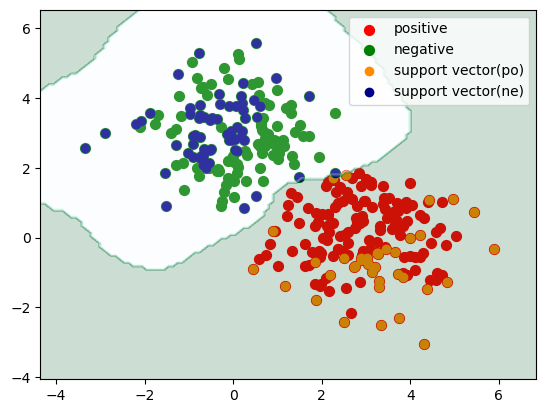

测试集可视化


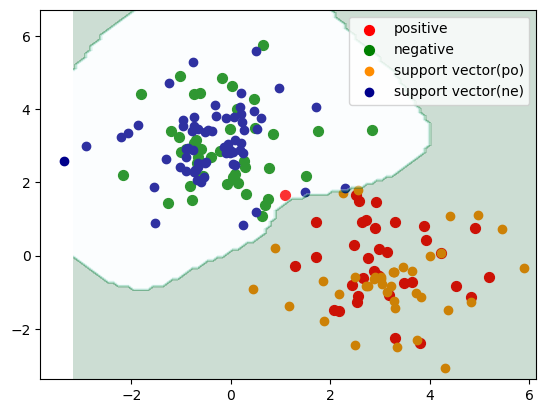

[  1   8  10  12  17  18  22  24  26  32  33  42  44  46  50  51  61  63
  64  68  70  71  74  76  78  80  83  84 100 102 109 112 113 114 115 116
 121 122 123 129 130 131 134 138 139 143 146 147 150 153 156 160 161 162
 164 166 179 181 188 190 198 199 200 204 205 207 208 211 213 214 219 231
 232 233 234 236 240 242 243 244 248 252 255 256 259 260 263 266 268 270
 275 281 282 285 289 291 294 297 302 303 306 307 309 312 314 316]


In [54]:
#尝试高斯核函数
sv_alpha,sv_idx,sv_label,sv_points,b=kernel_svm(train_set,'gauss')
print('训练集：')
eval(train_set,sv_alpha,sv_idx,sv_label,sv_points,b,'gauss')
print('测试集：')
eval(test_set,sv_alpha,sv_idx,sv_label,sv_points,b,'gauss')
print('训练集可视化')
draw(train_set,train_set,w,sv_alpha,sv_idx,sv_label,sv_points,b,'gauss')
print('测试集可视化')
draw(test_set,train_set,w,sv_alpha,sv_idx,sv_label,sv_points,b,'gauss')
print(sv_idx)

In [55]:
#坐标,这一部分是直接copy的
XC=[123.28,25.45,1]

## 仅仅使用沿海城市

x1=[119.28,26.08,#福州
121.31,25.03,#台北
121.47,31.23,#上海
118.06,24.27,#厦门
121.46,39.04,#大连
122.10,37.50,#威海
124.23,40.07]#丹东

x2=[129.87,32.75,#长崎
130.33,31.36,#鹿儿岛
131.42,31.91,#宫崎
130.24,33.35,#福冈
133.33,15.43,#鸟取
138.38,34.98,#静冈
140.47,36.37]#水户  

## 添加内陆城市

xp1=[119.28,26.08,#福州
121.31,25.03,#台北
121.47,31.23,#上海
118.06,24.27,#厦门
113.53,29.58,#武汉
104.06,30.67,#成都
116.25,39.54,#北京
121.46,39.04,#大连
122.10,37.50,#威海
124.23,40.07];#丹东

xp2=[129.87,32.75,#长崎
130.33,31.36,#鹿儿岛
131.42,31.91,#宫崎
130.24,33.35,#福冈
136.54,35.10,#名古屋
132.27,34.24,#广岛
139.46,35.42,#东京
133.33,15.43,#鸟取
138.38,34.98,#静冈
140.47,36.37],#水户

In [59]:
#通过augmented灵活选择是否包含内陆城市
x1=np.array(x1).reshape(-1,2)
x2=np.array(x2).reshape(-1,2)
xp1=np.array(xp1).reshape(-1,2)
xp2=np.array(xp2).reshape(-1,2)
augmented=True
ones1=np.ones((x1.shape[0],1))
ones2=np.ones((x2.shape[0],1))
ones11=np.ones((xp1.shape[0],1))
ones12=np.ones((xp2.shape[0],1))
if augmented==False:
    china=np.concatenate((ones1,x1,ones1),axis=-1)
    japen=np.concatenate((ones2,x2,-ones2),axis=-1)
else:
    china=np.concatenate((ones11,xp1,ones11),axis=-1)
    japen=np.concatenate((ones12,xp2,-ones12),axis=-1)
train_set=np.concatenate((china,japen),axis=0)
test_set=np.array([1,123.28,25.45,1]).reshape(1,-1)

     pcost       dcost       gap    pres   dres
 0: -6.8570e+00 -1.6753e+01  1e+01  1e-16  2e+00
 1: -8.3661e+00 -8.8396e+00  5e-01  2e-15  3e-01
 2: -8.8351e+00 -8.8714e+00  4e-02  2e-15  8e-17
 3: -8.8351e+00 -8.8355e+00  4e-04  8e-16  7e-17
 4: -8.8351e+00 -8.8351e+00  4e-06  8e-16  7e-17
Optimal solution found.
训练集：
正确率为:100.0%
测试集：
正确率为:100.0%
训练集可视化


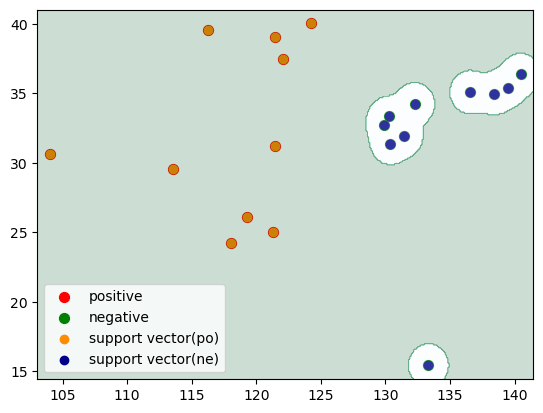

测试集可视化


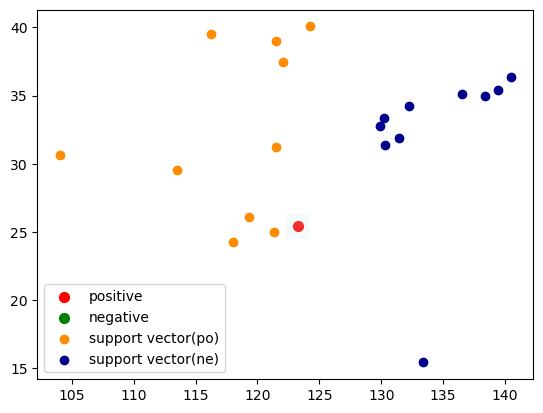

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [60]:
#尝试高斯核函数
sv_alpha,sv_idx,sv_label,sv_points,b=kernel_svm(train_set,'gauss')
print('训练集：')
eval(train_set,sv_alpha,sv_idx,sv_label,sv_points,b,'gauss')
print('测试集：')
eval(test_set,sv_alpha,sv_idx,sv_label,sv_points,b,'gauss')
print('训练集可视化')
draw(train_set,train_set,w,sv_alpha,sv_idx,sv_label,sv_points,b,'gauss')
print('测试集可视化')
draw(test_set,train_set,w,sv_alpha,sv_idx,sv_label,sv_points,b,'gauss')
print(sv_idx)